# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In this project I will train a traffic sign classifier on the [German Traffic Sign](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) data set with an aim for model performance on test data to have an accuracy of 93% or higher. During this project I also took the time to try to develop deeper intuitions for the hyperparameters and their effect on the accuracy of the model. I came up with a list of hyperparameters that I wanted to experiment with and defined a range of values each could take. I then trained the model with each distinct set of hyperparameters for 4 epochs and recorded the results in a CSV file and found my top performing models based on their validation accuracy. The second part of this notebook and corresponding writeup will be analyzing the results from the data I collected.

---
## Load Data  

You should only need to run this section once. It takes a few minutes to download.

In [1]:
import urllib.request
import zipfile
import os

try:
    os.remove('./traffic-signs-data.zip')
except OSError:
    pass
print('Beginning data download...')

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'  
urllib.request.urlretrieve(url, './traffic-signs-data.zip')
print('Data downloaded')
print('Unzipping')

z = zipfile.ZipFile('./traffic-signs-data.zip', 'r')
z.extractall('./data')
z.close()

try:
    os.remove('./traffic-signs-data.zip')
except OSError:
    pass

print('Done')

Beginning data download...
Data downloaded
Unzipping
Done


Here we are importing the following libraries:
* pickle - for loading data  
* numpy - array library and linear algebra operations  
* tensorflow - machine learning framework  

After importing we load the training, validation, and test data sets which have already been split for us and assigned to their respective feature set and feature label variables

In [1]:
import pickle
import numpy as np
import tensorflow as tf

In [2]:
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

Exploring the data set first is important so we can start asking the following questions:  
* Is there anything wrong with the data set that needs to be fixed? Examples: classes with really high frequencies relative to other classes, missing data, corrupted data, possible adversial agents manipulating training data, etc.
* What type of data are we working with? Is it images? If so, is the object in question in full view? Do the images need to be resized? 

Below we use pandas to show a table with some stats about our data set. Although the data sets were already split up if we were working with another data set we would have similar proportions for the percentage split given the same amount of training data. A common strategy for splitting up the data set is to do an 80/20 split for train/test data and then on the train set do another 80/20 split for train/valid. This puts the train set at 64%, validation set at 16%, and test set at 20%. It is worth nothing that with very large datasets you can begin reducing the percentage given to the validation and test set. 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plot import plot_images
%matplotlib inline
sns.set(style="dark", rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(sns.cubehelix_palette(8, start=.5, rot=-.50, reverse=True) * 6))

In [4]:
total_m = len(X_train) + len(X_valid) + len(X_test)
pd.DataFrame({
    "# Examples": [len(X_train), len(X_valid), len(X_test)],
    'Percent of total data': [len(X_train)/total_m * 100, len(X_valid)/total_m * 100,len(X_test)/total_m * 100],
    "Shape": [X_train[0].shape, X_valid[0].shape, X_test[0].shape],
    "# Classes": [max(y_train) + 1, max(y_valid) + 1, max(y_test) + 1]
},index=["TRAIN", "VALIDATION", "TEST"], columns=["# Examples", "Percent of total data", "Shape", "# Classes"])

,# Examples,Percent of total data,Shape,# Classes
TRAIN,34799,67.128996,"(32, 32, 3)",43
VALIDATION,4410,8.507109,"(32, 32, 3)",43
TEST,12630,24.363896,"(32, 32, 3)",43


Our goal is classify different traffic signs correctly so we should take a look at our classes and see what we are dealing with. You can see the classes with an example image from each class plotted out below. It is worth nothing that many of these signs are similar to one another. There are just a few groups of signs that are distinct geometrically. Additionally these signs have a pretty wide variance in lighting conditions which might help it generalize better.

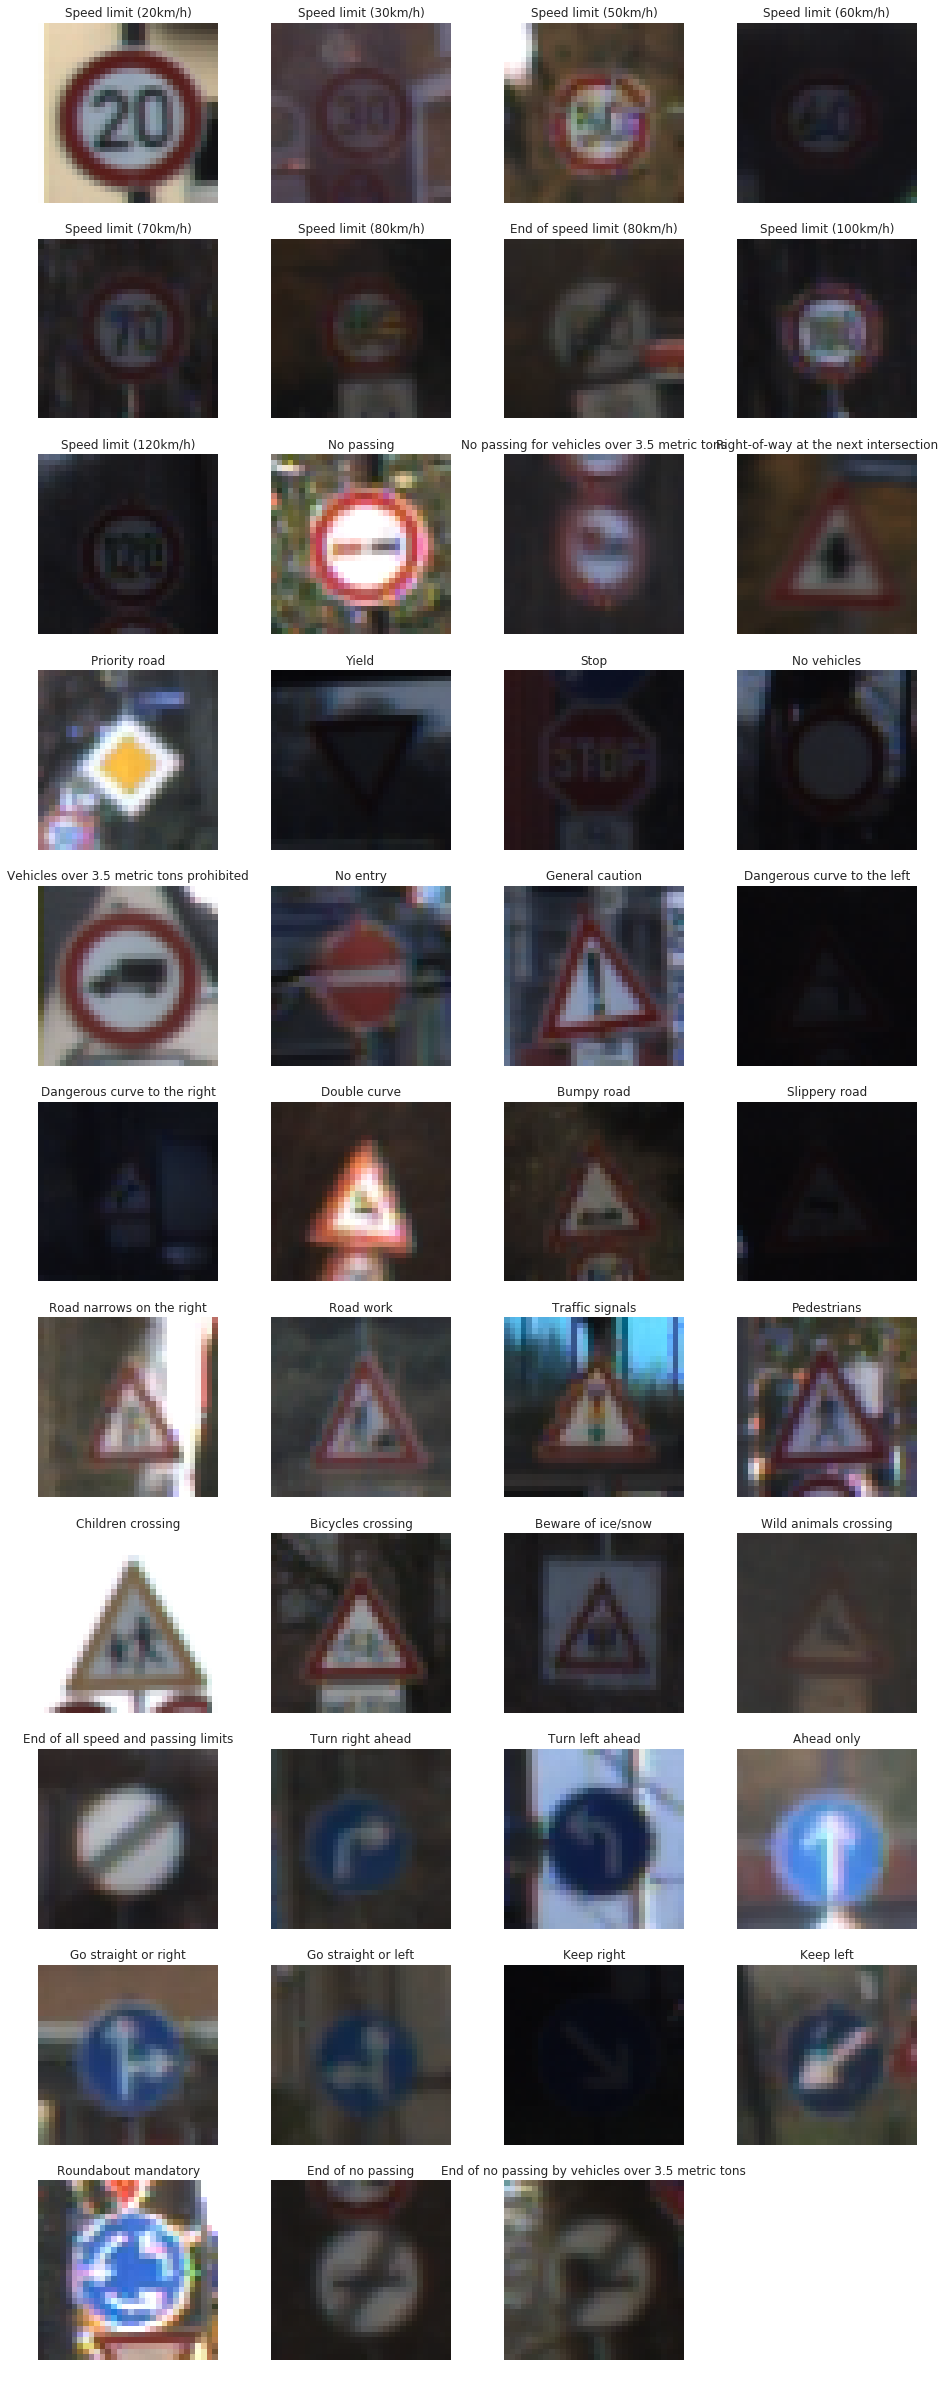

In [9]:
sign_names = pd.read_csv('signnames.csv')
_, unique_classes_idx = np.unique(y_train, return_index=True)
unique_class_examples = np.array(X_train)[unique_classes_idx]
plot_images(unique_class_examples, cols=4, labels=sign_names['SignName'])

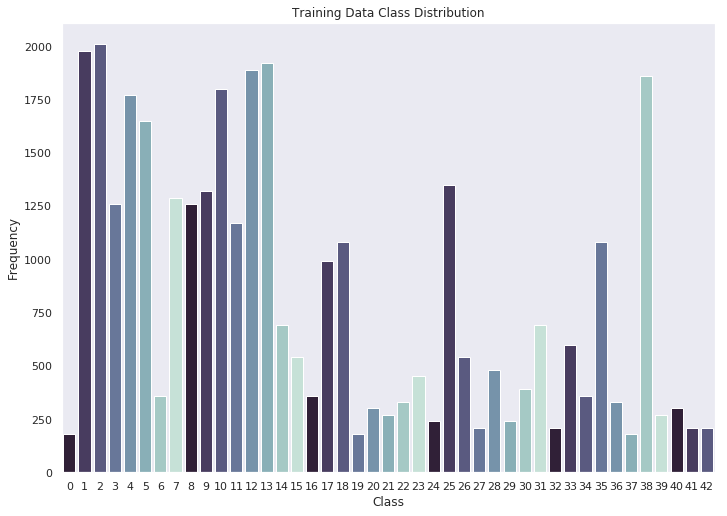

In [47]:
ax = sns.countplot(x=y_train)
ax.set(title="Training Data Class Distribution", xlabel='Class', ylabel="Frequency")
plt.show()

Above is a histogram of the class distribution. There are quite a few classes with really high frequency than others, some by factors of 12. Image augmentation is a method meant to address the unbalanced frequencies.

### Pre-process the Data Set  

We will begin by pre-processing the data set by converting the image to grayscale and then using mean normalization. Additionally we will use an image augmentation process to try to even out the frequency of the class distribution. We can augment images by changing the image to make it be perceived as a new image with operations such as flipping the image, zooming in, adding salt and pepper noise, rotating, and much more. In this particular implementation I use the roll, flip, and rotate operations which should be able to increase any given class by a factor of 9 at most.

In [9]:
from image import pre_process, augment
from sklearn.utils import shuffle 

In [10]:
X_train = pre_process(X_train)
X_valid = pre_process(X_valid)
X_test = pre_process(X_test)
X_aug, y_aug = augment(X_train, y_train)
X_aug, y_aug = shuffle(X_aug, y_aug.astype('int'))
X_aug = pre_process(X_aug)

Let's look at the frequency of classes in the augmented dataset:

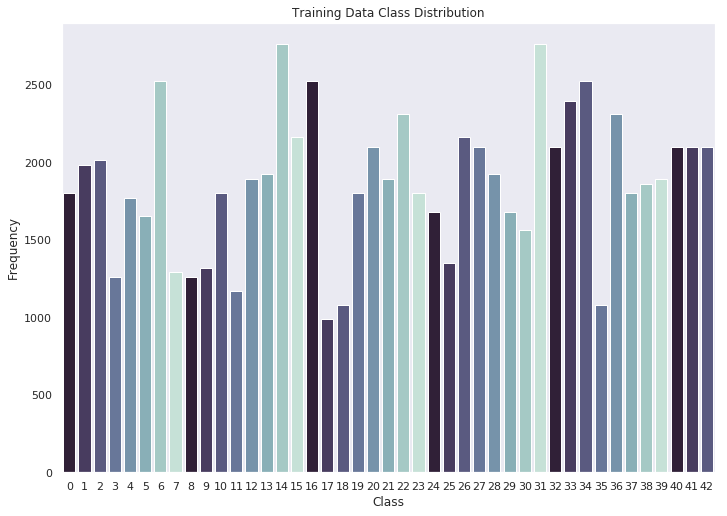

In [48]:
ax = sns.countplot(x=np.concatenate([y_train, y_aug]))
ax.set(title="Training Data Class Distribution", xlabel='Class', ylabel="Frequency")
plt.show()

It looks a little bit better but my algorithm could have used some improvement. Additionally it was only at the time of writing this that I realized the image augmentation was returning floats for the numeric values which may explain why the unaugmented data set outperformed the augmented one in the experiments I ran. I did something else that could be dangerous which was accidentally turned a few classes that once had the lowest frequency to classes that now have the highest frequency due to algorithm. Without really understanding your data this could lead to the model generalizing towards the class when  maybe there was a good reason for it having a low frequency. 

### Model Architecture  

We will only train one model in this jupyter notebook, but I trained 430 models with different hyperparameter sets to gain a better intuition of how hyperparameters affected the model. The hyperparameters we're using for this model was the winner from the top 5 showdown between the highest performing models.  

### Hyperparameters

* Learning Rate - 0.001 (The size of the steps we take to reach a minimum)
* Epochs - 30 (An epoch is one full pass of the training data through the neural network)
* Batch Size - 32 (Processing a small batch size instead of the entire training set at once will let us save memory and train faster)
* Augmentation - True (Whether or not training data is augmented)
* Architecture - CONV -> MAX_POOL -> RELU -> CONV -> MAX_POOL -> RELU -> FLATTEN -> FC -> DROPOUT -> RELU -> FC  

#### Intuition For Choice in Hyperparameters

The learning rate was the first hyperparameter I experimented with and found that either 1e-3 or 1e-4 was a good option based on trying out different values. Andrej Karpathy recommends 3e-4 for Adam as a starting point, but I have not read any justification for that exact number.  

The number of epochs was also a trial and error process I did before running the experiments. 

The stride of convolution layers, max pooling, and output size of fully connected layers were just picked and not changed during this learning process. I kept those values constant along with the learning rate and epochs. (*Note: I only learned after I ran the experiments that choosing even numbers for kernel size is not recommended and I would have gotten more interesting data by testing 1, 3, 5, and 7 instead*)

| Hyperparameter                 | Range                          |
|--------------------------------|--------------------------------|
| Data Augmented?                | True or False                  |
| Batch Size                     | 32, 64, 128                    |
| Dropout Keep Prob              | 0.4, 0.5, 0.6                  |
| Layer Architecture             | 1 Conv Layer or 2 Conv Layer   |
| Filters (1st layer, 2nd layer) | (16, 32), (32, 64), (64, 128)  |
| Conv Kernel Size               | (1, 1), (2, 2), (3, 3), (4, 4) |

In [12]:
from nn import NN

input_size = X_train[0].shape
num_labels = max(y_train) + 1
learning_rate = 0.001
epochs = 30
batch_size = 32
augment = True
dropout_keep_prob= 0.4
architecture = [
    { 'type': 'conv', 'filters': 64, 'ksize': [3, 3], 'stride': [1, 1] },
    { 'type': 'max_pool', 'ksize': [2, 2], 'stride': [2, 2] },
    { 'type': 'relu' },
    { 'type': 'conv', 'filters': 128, 'ksize': [3, 3], 'stride': [1, 1] },
    { 'type': 'max_pool', 'ksize': [2, 2], 'stride': [2, 2] },
    { 'type': 'relu' },
    { 'type': 'flatten' },
    { 'type': 'fc', 'units': 128 },
    { 'type': 'dropout' },
    { 'type': 'relu' },
    { 'type': 'fc', 'units': 43 }
]


tf.logging.set_verbosity(tf.logging.ERROR)

### Train the Model

With training we want to avoid overfitting by doing things like trainin the model for too long. Overfitting means that our network is beginning to memorize the training data which implies it is not making a good generalization about the data. Underfitting is just the opposite, but it seems that overfitting is an easier trap to fall into. For the optimizer we are using the Adam (adaptive moment estimation) optimizer whch is similar to stochastic gradient descent (SGD). One of the differences is that in SGD the optimizer maintains a single learning rate for all weights (the learning rate is a function of the momentum), whereas Adam will maintain a unique variable learning rate for each weight.

Below is an abstraction over the tensorflow API meant to reduce code clutter in the notebook.

In [13]:
network = NN(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
features = np.concatenate([X_train, aug_X]) if augment == 'True' else X_train
labels = np.concatenate([y_train, aug_y]) if augment == 'True' else y_train

network.add_train_data(features, labels)
network.add_test_data(X_test, y_test)
network.add_validation_data(X_valid, y_valid)

network.add_configuration(architecture, input_size=input_size)

network.build(num_labels=num_labels)
validation_accuracy = network.train(keep_prob=dropout_keep_prob)

Training...
EPOCH 1
Validation Accuracy = 0.747

EPOCH 2
Validation Accuracy = 0.893

EPOCH 3
Validation Accuracy = 0.922

EPOCH 4
Validation Accuracy = 0.945

EPOCH 5
Validation Accuracy = 0.966

EPOCH 6
Validation Accuracy = 0.968

EPOCH 7
Validation Accuracy = 0.975

EPOCH 8
Validation Accuracy = 0.980

EPOCH 9
Validation Accuracy = 0.983

EPOCH 10
Validation Accuracy = 0.979

EPOCH 11
Validation Accuracy = 0.978

EPOCH 12
Validation Accuracy = 0.982

EPOCH 13
Validation Accuracy = 0.984

EPOCH 14
Validation Accuracy = 0.980

EPOCH 15
Validation Accuracy = 0.981

EPOCH 16
Validation Accuracy = 0.983

EPOCH 17
Validation Accuracy = 0.982

EPOCH 18
Validation Accuracy = 0.982

EPOCH 19
Validation Accuracy = 0.982

EPOCH 20
Validation Accuracy = 0.973

EPOCH 21
Validation Accuracy = 0.982

EPOCH 22
Validation Accuracy = 0.985

EPOCH 23
Validation Accuracy = 0.983

EPOCH 24
Validation Accuracy = 0.985

EPOCH 25
Validation Accuracy = 0.983

EPOCH 26
Validation Accuracy = 0.976

EPOCH 27


From the visualization below we can see that after about the 10th epoch it just began fluctuating around a similar range of accuracy.

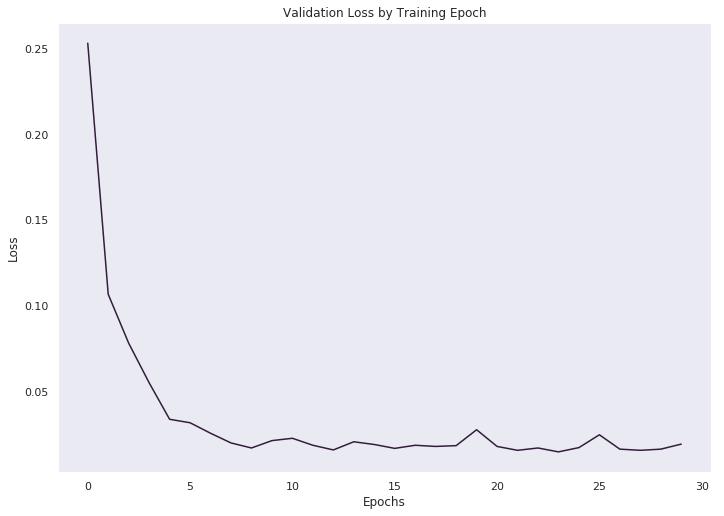

In [57]:
ax = sns.lineplot(x=list(range(epochs)), y=(1 - np.array(validation_accuracy)))
ax.set(title="Validation Loss by Training Epoch", xlabel='Epochs', ylabel="Loss")
plt.show()

### Test the Model

Finally we can test our model against new training data and see how well it does.

In [56]:
test_accuracy = network.test(save_name="savednetwork")

Test Accuracy = 0.968


Our accuracy on the test set is 96.8% which is a little bit lower than what we were getting on the validation set, but it is still pretty good. I did not go back and try to tune results from here as I felt that would sacrifice the integrity of the result and possibly appeal to test data.

---

## Test a Model on New Images

While we already tested the model on unseen data from the provided dataset, it would be interesting to see how well it perform on German traffic signs found outside of the dataset.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.